In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.0.0


In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
OP_DICT = ['zscore', 'cbrt', 'sigmoid', 'stdscaler']

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def create_f1():
    def f1_function(y_true, y_pred):
        y_pred_binary = tf.where(y_pred>=0.5, 1., 0.)
        y_true = tf.cast(y_true, dtype=tf.float32)
        tp = tf.reduce_sum(y_true * y_pred_binary)
        predicted_positives = tf.reduce_sum(y_pred_binary)
        possible_positives = tf.reduce_sum(y_true)
        return tp, predicted_positives, possible_positives
    return f1_function
class F1_score(keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.f1_function = create_f1()
        self.tp_count = self.add_weight("tp_count", initializer="zeros")
        self.all_predicted_positives = self.add_weight('all_predicted_positives', initializer='zeros')
        self.all_possible_positives = self.add_weight('all_possible_positives', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        tp, predicted_positives, possible_positives = self.f1_function(y_true, y_pred)
        self.tp_count.assign_add(tp)
        self.all_predicted_positives.assign_add(predicted_positives)
        self.all_possible_positives.assign_add(possible_positives)
    def result(self):
        precision = self.tp_count / self.all_predicted_positives
        recall = self.tp_count / self.all_possible_positives
        f1 = 2*(precision*recall)/(precision+recall)
        return f1

In [5]:
baseline_net = keras.Sequential([
            layers.Dense(450, activation='relu', input_shape=(200,)),
            layers.Dense(2, activation='softmax')
                ])
baseline_net.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
baseline_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 450)               90450     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 902       
Total params: 91,352
Trainable params: 91,352
Non-trainable params: 0
_________________________________________________________________


In [6]:
train_param = {
    'name': 'baseline',
    'data_dir': r"D:\!DTStack\Savefile_remote",
    'train_name':'basline_f1_score',
    'operator':OP_DICT,
    'model':baseline_net,
    'if_balanced':True,
    'balance_percent':0.4,
}

In [7]:
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.callbacks import Callback

class Metrics(Callback):
  def __init__(self, val_data, val_label):
      super(Callback, self).__init__()
      self.val_data = val_data
      self.val_label = val_label
  def on_train_begin(self, logs={}):
    self.val_f1s = []
  def on_epoch_end(self, epoch, logs={}):
    val_predict=(np.asarray(self.model.predict_classes(self.val_data,batch_size=1))).round()
    val_targ = self.val_label
    _val_f1 = f1_score(val_targ, val_predict, average='micro')
    self.val_f1s.append(_val_f1)
    print("— val_f1: %f " % _val_f1)
    return

Using TensorFlow backend.


In [8]:
class LFE_learner():
    
    def __init__(self,param):
        self.name = param['name']
        self.train_name = param['train_name']
        self.data_dir = param['data_dir']
        self.operator = param['operator']
        self.model = param['model']
        self.data_dir = os.path.join(self.data_dir, 'dataset', self.name)
        self.save_dir = os.path.join(self.data_dir, 'savefile', self.train_name)
        
        self.if_balanced = param['if_balanced']
        self.balance_percent = param['balance_percent']
        
    
    def train_forward(self,hyprprm = None):
        from keras.callbacks import TensorBoard
        from keras.callbacks import ModelCheckpoint
        import matplotlib.pyplot as plt
        
        for oprtr in self.operator:
            
            data_path = os.path.join(self.data_dir, oprtr, 'data.csv')
            data = self.load_data(data_path)
            
            x_train, x_test, y_train, y_test = self.split_data(data, test_size=0.2)

            model = self.init_network()
            
            tensorboard = tf.keras.callbacks.TensorBoard( log_dir = os.path.join(self.save_dir,oprtr,'log') )
            
            checkpoint = ModelCheckpoint(filepath=os.path.join(self.save_dir,oprtr,
                                                               "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"),
                                         monitor='val_accuracy',
                                         mode='auto',
                                         save_best_only=False,
                                         period = 50,
                                        )
            
            __metrics = Metrics(x_test,y_test)
            callback_lists=[tensorboard,checkpoint,__metrics]
        
            history = model.fit(x_train, y_train, 
                                batch_size=4, epochs=500, 
                                validation_data = (x_test,y_test),
                                verbose=1,
                                callbacks=callback_lists)
            
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.plot(__metrics.val_f1s)
            plt.legend(['training', 'validation','val_f1'], loc='lower left')
            plt.savefig(r'{}\{}.png'.format(self.save_dir,oprtr))
            plt.show()
            
            
    
    def split_data(self,data,test_size=0.2):
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(data[:,0:-1], data[:,-1], 
                                                            test_size=test_size, 
                                                            stratify = data[:,-1],
                                                            random_state=99)
        
        train_set = np.concatenate((x_train,y_train.reshape(-1,1)),axis = 1)
            
        if self.if_balanced:
            train_set = self.banlance_data(train_set,self.balance_percent)
            
        np.random.shuffle(train_set)
        
        return train_set[:,0:-1], x_test, train_set[:,-1], y_test
    
    
    
    def val_model(self,model_path ,oprtr ,if_pos = True):
        from keras.models import load_model
               
        data_path = os.path.join(self.data_dir, oprtr, 'data.csv')
        data = self.load_data(data_path)      
        
        x_train, x_test, y_train, y_test = self.split_data(data, test_size=0.2)
        
        if if_pos:
            x_test = pd.DataFrame (x_test)
            y_test = pd.DataFrame (y_test)
            idx = y_test.loc[y_test.iloc[:,-1]==1].index
            x_test = np.array(x_test.loc[idx] )
            y_test = np.array(y_test.loc[idx] )        


        
        model = tf.keras.models.load_model (model_path)
        
        return model.evaluate(x_test,y_test, batch_size = 4)
            
    
    def banlance_data(self,data,perc):
        df = pd.DataFrame(data)
        
        pos_data = df.loc[df.iloc[:,-1]==1]
        pos_num = len(pos_data)
        total_num = len(df)
        
        oversample_num = int(  ( perc*total_num - (1.0+perc)*pos_num )/(1-perc)  )
        df = pd.concat([df,pos_data.sample(n=oversample_num,replace=True,axis=0)],axis =0)
        
        return np.array(df)
        
    def init_network(self):
        return self.model
    
        
    def load_data(self,path):
        return np.array(pd.read_csv(path,header=None))
        
    

In [9]:
lqf = LFE_learner(train_param)

In [ ]:
df = lqf.train_forward()

Train on 1898 samples, validate on 331 samples
Epoch 1/500
1898/1898 [==============================] - 2s 1ms/sample - loss: 0.6548 - accuracy: 0.6275 - val_loss: 0.5045 - val_accuracy: 0.8973
Epoch 2/500
1898/1898 [==============================] - 1s 622us/sample - loss: 0.6329 - accuracy: 0.6475 - val_loss: 0.4475 - val_accuracy: 0.8912
Epoch 3/500
1898/1898 [==============================] - 1s 600us/sample - loss: 0.6182 - accuracy: 0.6502 - val_loss: 0.4928 - val_accuracy: 0.8822
Epoch 4/500
1898/1898 [==============================] - 1s 610us/sample - loss: 0.5981 - accuracy: 0.6691 - val_loss: 0.5097 - val_accuracy: 0.8761
Epoch 5/500
1898/1898 [==============================] - 1s 620us/sample - loss: 0.5848 - accuracy: 0.6818 - val_loss: 0.4332 - val_accuracy: 0.8912
Epoch 6/500
1898/1898 [==============================] - 1s 635us/sample - loss: 0.5707 - accuracy: 0.6944 - val_loss: 0.5858 - val_accuracy: 0.7795
Epoch 7/500
1898/1898 [==============================] - 1s 7

Epoch 33/500
1898/1898 [==============================] - 1s 718us/sample - loss: 0.3257 - accuracy: 0.8577 - val_loss: 1.0387 - val_accuracy: 0.7341
Epoch 34/500
1898/1898 [==============================] - 1s 706us/sample - loss: 0.3206 - accuracy: 0.8646 - val_loss: 0.9643 - val_accuracy: 0.8097
Epoch 35/500
1898/1898 [==============================] - 1s 634us/sample - loss: 0.3168 - accuracy: 0.8667 - val_loss: 0.9646 - val_accuracy: 0.8036
Epoch 36/500
1898/1898 [==============================] - 1s 711us/sample - loss: 0.3167 - accuracy: 0.8678 - val_loss: 0.9949 - val_accuracy: 0.7885
Epoch 37/500
1898/1898 [==============================] - 1s 632us/sample - loss: 0.3115 - accuracy: 0.8736 - val_loss: 1.0089 - val_accuracy: 0.7795
Epoch 38/500
1898/1898 [==============================] - 1s 592us/sample - loss: 0.3066 - accuracy: 0.8783 - val_loss: 1.0285 - val_accuracy: 0.7915
Epoch 39/500
1898/1898 [==============================] - 1s 590us/sample - loss: 0.3049 - accuracy:

1898/1898 [==============================] - 1s 661us/sample - loss: 0.2564 - accuracy: 0.9078 - val_loss: 1.2425 - val_accuracy: 0.8066
Epoch 66/500
1898/1898 [==============================] - 1s 613us/sample - loss: 0.2632 - accuracy: 0.8973 - val_loss: 1.2920 - val_accuracy: 0.7523
Epoch 67/500
1898/1898 [==============================] - 1s 762us/sample - loss: 0.2591 - accuracy: 0.9073 - val_loss: 1.2654 - val_accuracy: 0.7855
Epoch 68/500
1898/1898 [==============================] - 1s 624us/sample - loss: 0.2566 - accuracy: 0.9009 - val_loss: 1.2463 - val_accuracy: 0.8006
Epoch 69/500
1898/1898 [==============================] - 1s 667us/sample - loss: 0.2536 - accuracy: 0.9031 - val_loss: 1.2281 - val_accuracy: 0.8399
Epoch 70/500
1898/1898 [==============================] - 1s 708us/sample - loss: 0.2512 - accuracy: 0.9046 - val_loss: 1.2426 - val_accuracy: 0.8248
Epoch 71/500
1898/1898 [==============================] - 1s 608us/sample - loss: 0.2544 - accuracy: 0.9094 - val

1898/1898 [==============================] - 2s 921us/sample - loss: 0.2349 - accuracy: 0.9152 - val_loss: 1.3557 - val_accuracy: 0.7855
Epoch 98/500
1898/1898 [==============================] - 2s 872us/sample - loss: 0.2301 - accuracy: 0.9141 - val_loss: 1.3293 - val_accuracy: 0.8399
Epoch 99/500
1898/1898 [==============================] - 1s 680us/sample - loss: 0.2319 - accuracy: 0.9104 - val_loss: 1.3590 - val_accuracy: 0.8036
Epoch 100/500
1898/1898 [==============================] - 1s 649us/sample - loss: 0.2295 - accuracy: 0.9157 - val_loss: 1.3524 - val_accuracy: 0.8006
Epoch 101/500
1898/1898 [==============================] - 1s 609us/sample - loss: 0.2310 - accuracy: 0.9178 - val_loss: 1.3503 - val_accuracy: 0.8127
Epoch 102/500
1898/1898 [==============================] - 2s 842us/sample - loss: 0.2320 - accuracy: 0.9152 - val_loss: 1.3664 - val_accuracy: 0.8006
Epoch 103/500
1898/1898 [==============================] - 1s 602us/sample - loss: 0.2309 - accuracy: 0.9157 -

Epoch 129/500
1898/1898 [==============================] - 1s 662us/sample - loss: 0.2194 - accuracy: 0.9252 - val_loss: 1.4525 - val_accuracy: 0.8066
Epoch 130/500
1898/1898 [==============================] - 1s 640us/sample - loss: 0.2210 - accuracy: 0.9231 - val_loss: 1.4656 - val_accuracy: 0.8036
Epoch 131/500
1898/1898 [==============================] - 1s 634us/sample - loss: 0.2172 - accuracy: 0.9236 - val_loss: 1.4423 - val_accuracy: 0.8127
Epoch 132/500
1898/1898 [==============================] - 1s 656us/sample - loss: 0.2214 - accuracy: 0.9204 - val_loss: 1.4289 - val_accuracy: 0.8006
Epoch 133/500
1898/1898 [==============================] - 1s 631us/sample - loss: 0.2160 - accuracy: 0.9289 - val_loss: 1.4672 - val_accuracy: 0.8127
Epoch 134/500
1898/1898 [==============================] - 1s 624us/sample - loss: 0.2168 - accuracy: 0.9220 - val_loss: 1.4499 - val_accuracy: 0.8097
Epoch 135/500
1898/1898 [==============================] - 1s 643us/sample - loss: 0.2159 - ac

Epoch 161/500
1898/1898 [==============================] - 1s 663us/sample - loss: 0.2106 - accuracy: 0.9315 - val_loss: 1.5359 - val_accuracy: 0.8127
Epoch 162/500
1898/1898 [==============================] - 1s 616us/sample - loss: 0.2093 - accuracy: 0.9283 - val_loss: 1.5623 - val_accuracy: 0.8308
Epoch 163/500
1898/1898 [==============================] - 1s 646us/sample - loss: 0.2092 - accuracy: 0.9273 - val_loss: 1.5445 - val_accuracy: 0.7885
Epoch 164/500
1898/1898 [==============================] - 1s 748us/sample - loss: 0.2108 - accuracy: 0.9305 - val_loss: 1.5604 - val_accuracy: 0.8127
Epoch 165/500
1898/1898 [==============================] - 1s 685us/sample - loss: 0.2123 - accuracy: 0.9257 - val_loss: 1.5456 - val_accuracy: 0.8036
Epoch 166/500
1898/1898 [==============================] - 1s 639us/sample - loss: 0.2107 - accuracy: 0.9257 - val_loss: 1.5575 - val_accuracy: 0.8278
Epoch 167/500
1898/1898 [==============================] - 1s 650us/sample - loss: 0.2052 - ac

Epoch 193/500
1898/1898 [==============================] - 1s 589us/sample - loss: 0.2020 - accuracy: 0.9347 - val_loss: 1.6334 - val_accuracy: 0.8127
Epoch 194/500
1898/1898 [==============================] - 1s 588us/sample - loss: 0.2044 - accuracy: 0.9331 - val_loss: 1.6096 - val_accuracy: 0.8036
Epoch 195/500
1898/1898 [==============================] - 1s 613us/sample - loss: 0.2051 - accuracy: 0.9305 - val_loss: 1.5826 - val_accuracy: 0.8187
Epoch 196/500
1898/1898 [==============================] - 1s 597us/sample - loss: 0.2004 - accuracy: 0.9326 - val_loss: 1.6055 - val_accuracy: 0.8036
Epoch 197/500
1898/1898 [==============================] - 1s 595us/sample - loss: 0.2027 - accuracy: 0.9315 - val_loss: 1.6102 - val_accuracy: 0.8097
Epoch 198/500
1898/1898 [==============================] - 1s 584us/sample - loss: 0.2048 - accuracy: 0.9315 - val_loss: 1.6260 - val_accuracy: 0.8308
Epoch 199/500
1898/1898 [==============================] - 1s 596us/sample - loss: 0.2102 - ac

Epoch 225/500
1898/1898 [==============================] - 1s 581us/sample - loss: 0.2041 - accuracy: 0.9294 - val_loss: 1.6401 - val_accuracy: 0.8369
Epoch 226/500
1898/1898 [==============================] - 1s 587us/sample - loss: 0.1991 - accuracy: 0.9341 - val_loss: 1.6421 - val_accuracy: 0.8338
Epoch 227/500
1898/1898 [==============================] - 1s 596us/sample - loss: 0.1963 - accuracy: 0.9352 - val_loss: 1.6656 - val_accuracy: 0.7976
Epoch 228/500
1898/1898 [==============================] - 1s 630us/sample - loss: 0.2014 - accuracy: 0.9294 - val_loss: 1.6300 - val_accuracy: 0.8248
Epoch 229/500
1898/1898 [==============================] - 1s 739us/sample - loss: 0.1966 - accuracy: 0.9310 - val_loss: 1.6273 - val_accuracy: 0.8278
Epoch 230/500
1898/1898 [==============================] - 1s 577us/sample - loss: 0.2041 - accuracy: 0.9299 - val_loss: 1.6652 - val_accuracy: 0.8308
Epoch 231/500
1898/1898 [==============================] - 1s 606us/sample - loss: 0.2004 - ac

Epoch 257/500
1898/1898 [==============================] - 1s 581us/sample - loss: 0.1942 - accuracy: 0.9347 - val_loss: 1.6883 - val_accuracy: 0.8308
Epoch 258/500
1898/1898 [==============================] - 1s 573us/sample - loss: 0.1951 - accuracy: 0.9341 - val_loss: 1.7110 - val_accuracy: 0.8248
Epoch 259/500
1898/1898 [==============================] - 1s 562us/sample - loss: 0.1977 - accuracy: 0.9294 - val_loss: 1.6838 - val_accuracy: 0.8308
Epoch 260/500
1898/1898 [==============================] - 1s 544us/sample - loss: 0.1967 - accuracy: 0.9357 - val_loss: 1.7274 - val_accuracy: 0.8369
Epoch 261/500
1898/1898 [==============================] - 1s 768us/sample - loss: 0.1968 - accuracy: 0.9357 - val_loss: 1.6892 - val_accuracy: 0.8278
Epoch 262/500
1898/1898 [==============================] - 1s 703us/sample - loss: 0.1989 - accuracy: 0.9305 - val_loss: 1.7091 - val_accuracy: 0.8218
Epoch 263/500
1898/1898 [==============================] - 1s 751us/sample - loss: 0.1973 - ac

Epoch 289/500
1898/1898 [==============================] - 1s 632us/sample - loss: 0.1964 - accuracy: 0.9341 - val_loss: 1.7408 - val_accuracy: 0.8308
Epoch 290/500
1898/1898 [==============================] - 1s 614us/sample - loss: 0.1963 - accuracy: 0.9326 - val_loss: 1.7247 - val_accuracy: 0.8278
Epoch 291/500
1898/1898 [==============================] - 1s 569us/sample - loss: 0.1894 - accuracy: 0.9341 - val_loss: 1.7492 - val_accuracy: 0.8248
Epoch 292/500
1898/1898 [==============================] - 1s 619us/sample - loss: 0.1952 - accuracy: 0.9362 - val_loss: 1.7580 - val_accuracy: 0.8036
Epoch 293/500
1898/1898 [==============================] - 1s 626us/sample - loss: 0.1967 - accuracy: 0.9315 - val_loss: 1.7500 - val_accuracy: 0.8308
Epoch 294/500
1898/1898 [==============================] - 1s 589us/sample - loss: 0.1925 - accuracy: 0.9352 - val_loss: 1.7471 - val_accuracy: 0.8278
Epoch 295/500
1898/1898 [==============================] - 1s 604us/sample - loss: 0.1943 - ac

Epoch 321/500
1898/1898 [==============================] - 1s 593us/sample - loss: 0.1910 - accuracy: 0.9336 - val_loss: 1.7647 - val_accuracy: 0.8369
Epoch 322/500
1898/1898 [==============================] - 1s 631us/sample - loss: 0.1921 - accuracy: 0.9362 - val_loss: 1.7969 - val_accuracy: 0.8369
Epoch 323/500
1898/1898 [==============================] - 1s 613us/sample - loss: 0.1926 - accuracy: 0.9352 - val_loss: 1.7982 - val_accuracy: 0.8308
Epoch 324/500
1898/1898 [==============================] - 1s 653us/sample - loss: 0.1923 - accuracy: 0.9362 - val_loss: 1.7911 - val_accuracy: 0.8369
Epoch 325/500
1898/1898 [==============================] - 1s 669us/sample - loss: 0.1940 - accuracy: 0.9347 - val_loss: 1.7823 - val_accuracy: 0.8369
Epoch 326/500
1898/1898 [==============================] - 1s 691us/sample - loss: 0.1950 - accuracy: 0.9320 - val_loss: 1.8178 - val_accuracy: 0.8429
Epoch 327/500
1898/1898 [==============================] - 1s 659us/sample - loss: 0.1921 - ac

Epoch 353/500
1898/1898 [==============================] - 1s 575us/sample - loss: 0.1955 - accuracy: 0.9331 - val_loss: 1.8568 - val_accuracy: 0.8369
Epoch 354/500
1898/1898 [==============================] - 1s 578us/sample - loss: 0.1894 - accuracy: 0.9389 - val_loss: 1.8548 - val_accuracy: 0.8218
Epoch 355/500
1898/1898 [==============================] - 1s 587us/sample - loss: 0.1941 - accuracy: 0.9362 - val_loss: 1.8580 - val_accuracy: 0.8369
Epoch 356/500
1898/1898 [==============================] - 1s 624us/sample - loss: 0.1868 - accuracy: 0.9347 - val_loss: 1.8466 - val_accuracy: 0.8218
Epoch 357/500
1898/1898 [==============================] - 1s 613us/sample - loss: 0.1878 - accuracy: 0.9389 - val_loss: 1.8695 - val_accuracy: 0.8248
Epoch 358/500
1898/1898 [==============================] - 1s 761us/sample - loss: 0.1874 - accuracy: 0.9357 - val_loss: 1.8861 - val_accuracy: 0.8369
Epoch 359/500
1898/1898 [==============================] - 1s 596us/sample - loss: 0.1885 - ac

Epoch 385/500
1898/1898 [==============================] - 1s 571us/sample - loss: 0.1891 - accuracy: 0.9384 - val_loss: 1.9336 - val_accuracy: 0.8369
Epoch 386/500
1898/1898 [==============================] - 1s 590us/sample - loss: 0.1915 - accuracy: 0.9315 - val_loss: 1.9517 - val_accuracy: 0.8157
Epoch 387/500
1898/1898 [==============================] - 1s 570us/sample - loss: 0.1902 - accuracy: 0.9399 - val_loss: 1.9340 - val_accuracy: 0.8308
Epoch 388/500
1898/1898 [==============================] - 1s 578us/sample - loss: 0.1894 - accuracy: 0.9389 - val_loss: 1.9003 - val_accuracy: 0.8308
Epoch 389/500
1898/1898 [==============================] - 1s 597us/sample - loss: 0.1847 - accuracy: 0.9373 - val_loss: 1.9269 - val_accuracy: 0.8369
Epoch 390/500
1898/1898 [==============================] - 1s 577us/sample - loss: 0.1892 - accuracy: 0.9357 - val_loss: 1.9470 - val_accuracy: 0.8338
Epoch 391/500
1898/1898 [==============================] - 1s 626us/sample - loss: 0.1912 - ac

Epoch 417/500
1898/1898 [==============================] - 1s 626us/sample - loss: 0.1866 - accuracy: 0.9357 - val_loss: 1.9610 - val_accuracy: 0.8369
Epoch 418/500
1898/1898 [==============================] - 1s 606us/sample - loss: 0.1856 - accuracy: 0.9389 - val_loss: 1.9855 - val_accuracy: 0.8369
Epoch 419/500
1898/1898 [==============================] - 1s 659us/sample - loss: 0.1882 - accuracy: 0.9368 - val_loss: 1.9755 - val_accuracy: 0.8278
Epoch 420/500
1898/1898 [==============================] - 1s 696us/sample - loss: 0.1887 - accuracy: 0.9357 - val_loss: 1.9837 - val_accuracy: 0.8338
Epoch 421/500
1898/1898 [==============================] - 1s 585us/sample - loss: 0.1886 - accuracy: 0.9362 - val_loss: 2.0108 - val_accuracy: 0.8369
Epoch 422/500
1898/1898 [==============================] - 1s 604us/sample - loss: 0.1888 - accuracy: 0.9326 - val_loss: 1.9817 - val_accuracy: 0.8308
Epoch 423/500
1898/1898 [==============================] - 1s 590us/sample - loss: 0.1875 - ac

Epoch 449/500
1898/1898 [==============================] - 1s 587us/sample - loss: 0.1878 - accuracy: 0.9389 - val_loss: 2.0394 - val_accuracy: 0.8308
Epoch 450/500
1898/1898 [==============================] - 1s 603us/sample - loss: 0.1854 - accuracy: 0.9362 - val_loss: 2.0424 - val_accuracy: 0.8369
Epoch 451/500
1898/1898 [==============================] - 1s 668us/sample - loss: 0.1860 - accuracy: 0.9378 - val_loss: 2.0396 - val_accuracy: 0.8369
Epoch 452/500
1898/1898 [==============================] - 1s 618us/sample - loss: 0.1864 - accuracy: 0.9352 - val_loss: 2.0345 - val_accuracy: 0.8369
Epoch 453/500
1898/1898 [==============================] - 1s 596us/sample - loss: 0.1875 - accuracy: 0.9373 - val_loss: 2.0375 - val_accuracy: 0.8369
Epoch 454/500
1204/1898 [==================>...........] - ETA: 0s - loss: 0.1930 - accuracy: 0.9311

In [29]:
val_df = lqf.val_model(
    model_path = r"D:\!DTStack\Savefile_remote\dataset\baseline\savefile\basline_balanced\stdscaler\weights-improvement-500-0.93.hdf5",
    oprtr = 'stdscaler')
print (val_df)

10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 5ms/sample - loss: 17.6120 - accuracy: 0.1000
[21.444822311401367, 0.1]


[21.444822311401367, 0.1]


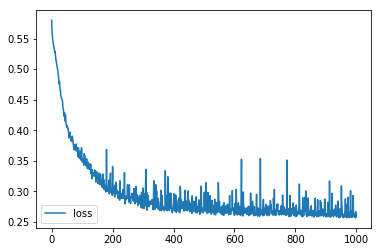

In [19]:
plt.plot(history.history['loss'])
plt.legend(['loss'], loc='lower left')
plt.show()

In [8]:
LFE_MLP_net = keras.Sequential([
            layers.Dense(500, activation='relu', input_shape=(200,)),
            layers.Dense(500, activation='relu'),
            layers.Dense(1, activation='sigmoid')
                ])
LFE_MLP_net.compile(optimizer=keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
LFE_MLP_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 501       
Total params: 351,501
Trainable params: 351,501
Non-trainable params: 0
_________________________________________________________________
